In [1]:
import sys
sys.path.insert(0, '../src/data')
import pandas as pd
import geopandas as gpd
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import bame_datastore
bame_datastore.lib

Found local clean copy of Local_Authority_Districts__December_2009__Boundaries
Found local clean copy of fbook_covid_cases
Found local clean copy of BAME_report_cases
Found local clean copy of BAME_report_deaths
Found local clean copy of bame_excess_deaths
Found local clean copy of ons_deaths
Found local clean copy of ethnicity_2011
Found local clean copy of furlough_data
Found local clean copy of key_workers
Found local clean copy of deprivation_data


{'mortality': ['fbook_covid_data',
  'bame_rpt_deaths',
  'bame_rpt_excess_deaths',
  'ons_deaths'],
 'explanatory': ['ethnicity_data',
  'bame_rpt_cases',
  'furlough_data',
  'key_workers',
  'deprivation'],
 'other': ['lad_geog']}

In [3]:
ons_deaths_df = bame_datastore.ons_deaths.df
ethnicity_df = bame_datastore.ethnicity_data.df
df = ons_deaths_df.join(ethnicity_df) # join the deaths and ethnicity data by local authority
df.dropna(subset=["Denominator"], inplace=True)
df.columns

Index(['Sex', 'Geography', 'Area code', 'all_Deaths', 'all_Rate',
       'all Lower CI', 'all Upper CI', 'covid_Deaths', 'covid_Rate',
       'covid Lower CI', 'covid Upper CI', 'Geography_code', 'Denominator',
       'Arab', 'Asian', 'Asian Other', 'Bangladeshi', 'Black', 'Black African',
       'Black Caribbean', 'Black Other', 'Chinese', 'Indian', 'Mixed',
       'Mixed Other', 'Mixed White and Asian', 'Mixed White and Black African',
       'Mixed White and Black Caribbean', 'Other', 'Other ethnic group',
       'Pakistani', 'White', 'White British', 'White Gypsy or Irish Traveller',
       'White Irish', 'White Other'],
      dtype='object')

In [4]:
def reg_plot(df, cov_death_col):
    """Takes in DataFrame and name of covid death column"""
    fig, ax = plt.subplots(figsize=(20,10))

    corr_capture = {}
    for i in df.columns[13:36]: #itterate throught the ethnicities
        correlation = df[cov_death_col].corr(df[i])
        corr_capture[i] = correlation

        ax = sns.regplot(x=i, y=cov_death_col, data=df, label=i)

    ax.legend()
    plt.legend(loc='upper right')
    ax.set_title(f'Relationship between {cov_death_col} and ethnicity broken down by Local Authority District')
    ax.set_xlabel('% of local population in this ethnic group - 2011 Census')
    ax.set_ylabel('number of deaths in the local authority district')

    plt.savefig(f"../reports/figures/regplot{cov_death_col}.png")

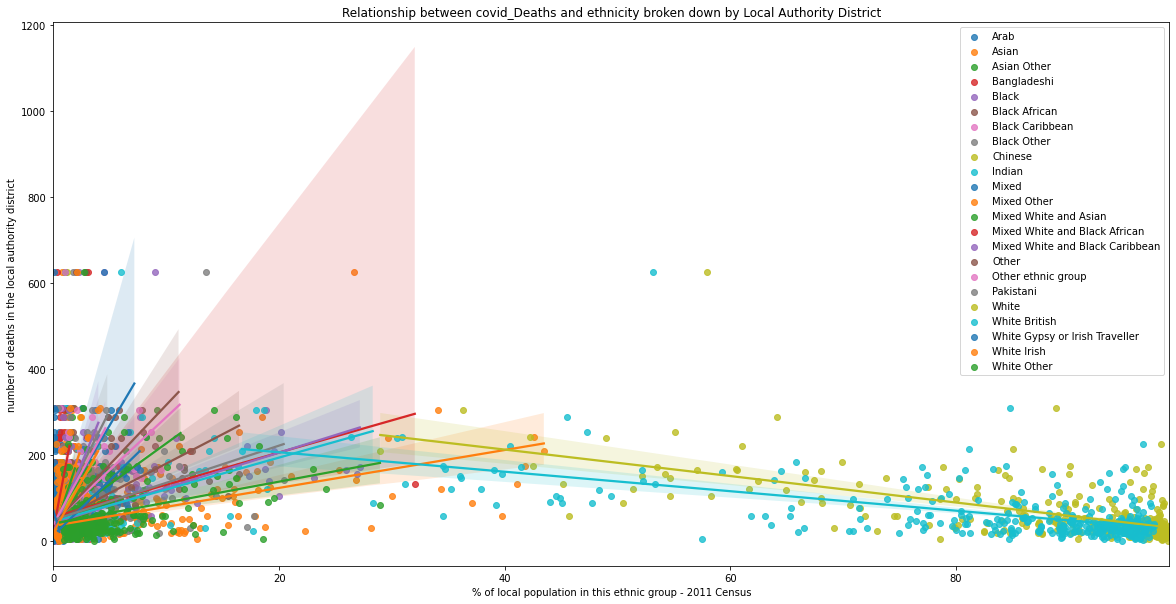

In [5]:
reg_plot(df, "covid_Deaths")

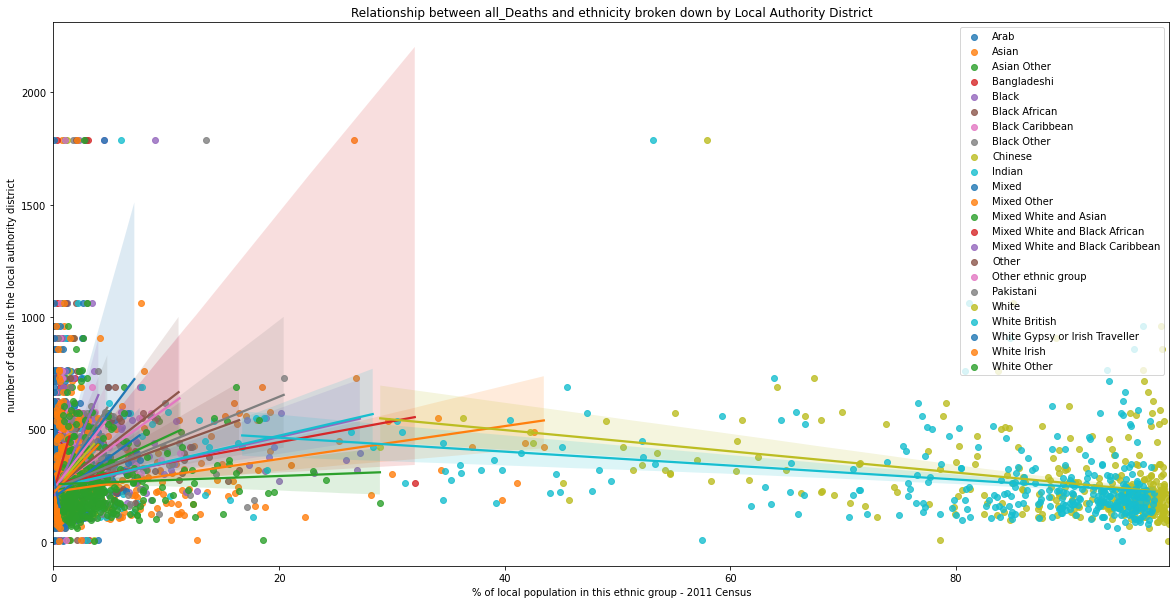

In [6]:
reg_plot(df, "all_Deaths")

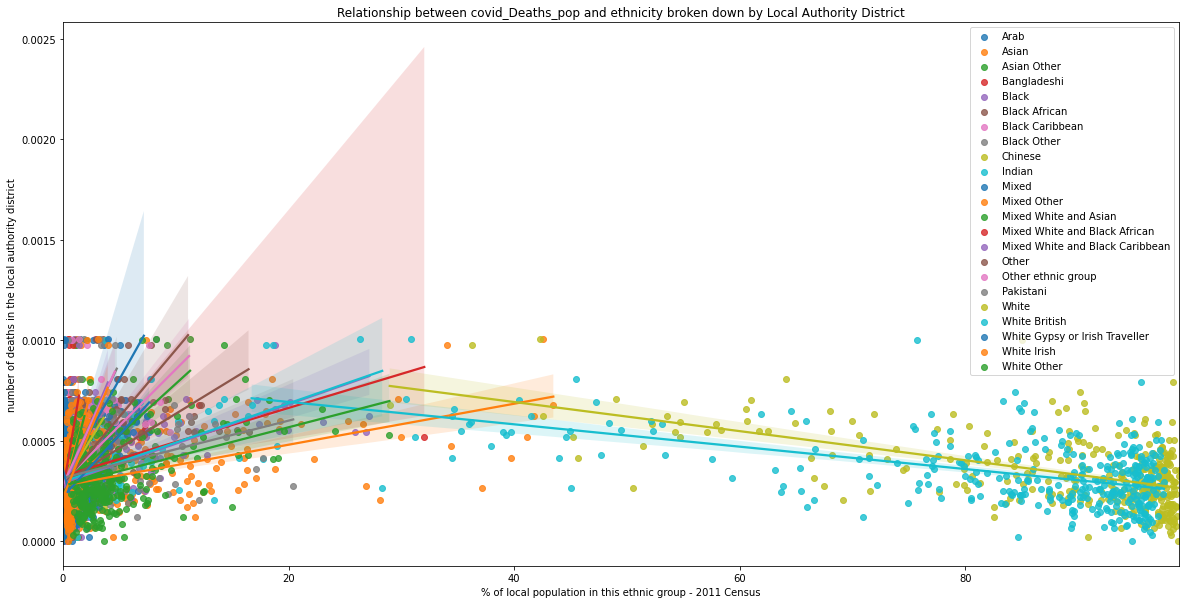

In [7]:
df[df.columns[5]] = df["covid_Deaths"]/df["Denominator"] # normalise deaths by population
df.rename(columns={df.columns[5]:'covid_Deaths_pop'}, inplace=True)
reg_plot(df, "covid_Deaths_pop")

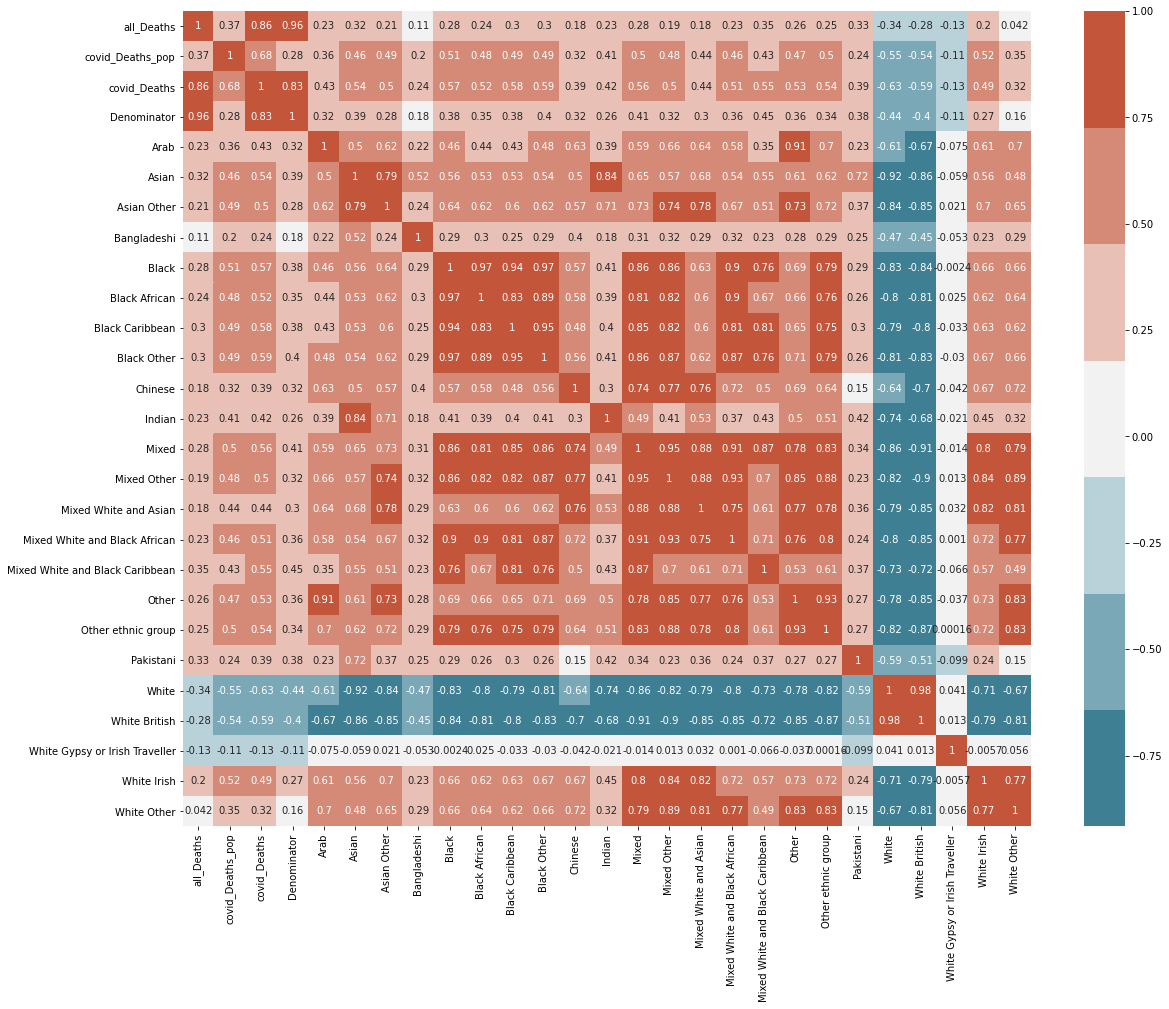

In [8]:
#correlation matrix of relevant variables
plt.figure(figsize=(19, 15))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat.png")

# Grouping Ethnicities
Grouping ethnicities based on the [5 broad ethnic groups](https://www.ethnicity-facts-figures.service.gov.uk/ethnic-groups) used by the goverment. However in doing so we are already losing the heterogeneity wthin these broad categories and may be missing the differing impacts within them.  

In [9]:
df_grouped = df.iloc[:,:6].copy() # target data

# sum groups to get total share
df_grouped["White"] = df[['White', 'White British','White Gypsy or Irish Traveller', 'White Irish', 'White Other']].sum(axis=1)
df_grouped["Mixed"] = df[['Mixed White and Black Caribbean','Mixed White and Asian',
                          'Mixed White and Black African', 'Mixed', 'Mixed Other', ]].sum(axis=1)
df_grouped["Black_African_Caribbean"] = df[['Black', 'Black African', 'Black Caribbean', 'Black Other']].sum(axis=1)
df_grouped["Asian"] = df[['Asian', 'Asian Other', 'Bangladeshi','Chinese','Indian', 'Pakistani', ]].sum(axis=1)
df_grouped["Other"] = df[[ 'Arab','Other', 'Other ethnic group', ]].sum(axis=1)

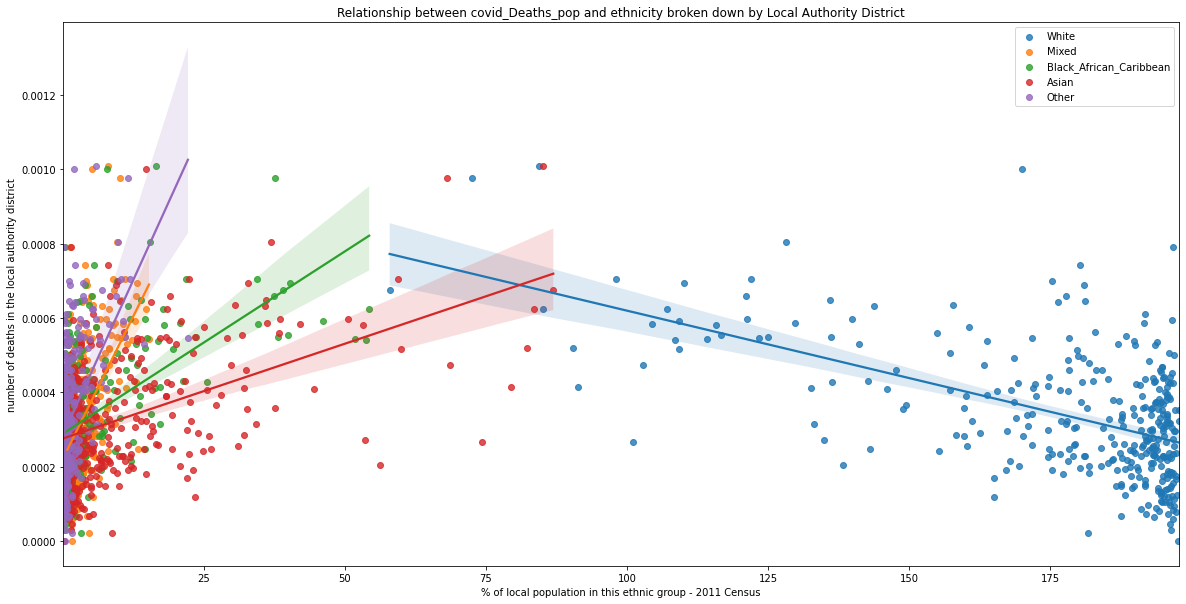

In [10]:
def reg_plot_alt(df, cov_death_col):
    """Takes in DataFrame and name of covid death column"""
    fig, ax = plt.subplots(figsize=(20,10))

    corr_capture = {}
    for i in df_grouped.columns[6:]: #itterate throught the ethnicities
        correlation = df[cov_death_col].corr(df[i])
        corr_capture[i] = correlation

        ax = sns.regplot(x=i, y=cov_death_col, data=df, label=i)

    ax.legend()
    plt.legend(loc='upper right')
    ax.set_title(f'Relationship between {cov_death_col} and ethnicity broken down by Local Authority District')
    ax.set_xlabel('% of local population in this ethnic group - 2011 Census')
    ax.set_ylabel('number of deaths in the local authority district')

    plt.savefig(f"../reports/figures/regplot{cov_death_col}grouped.png")

reg_plot_alt(df_grouped, "covid_Deaths_pop")

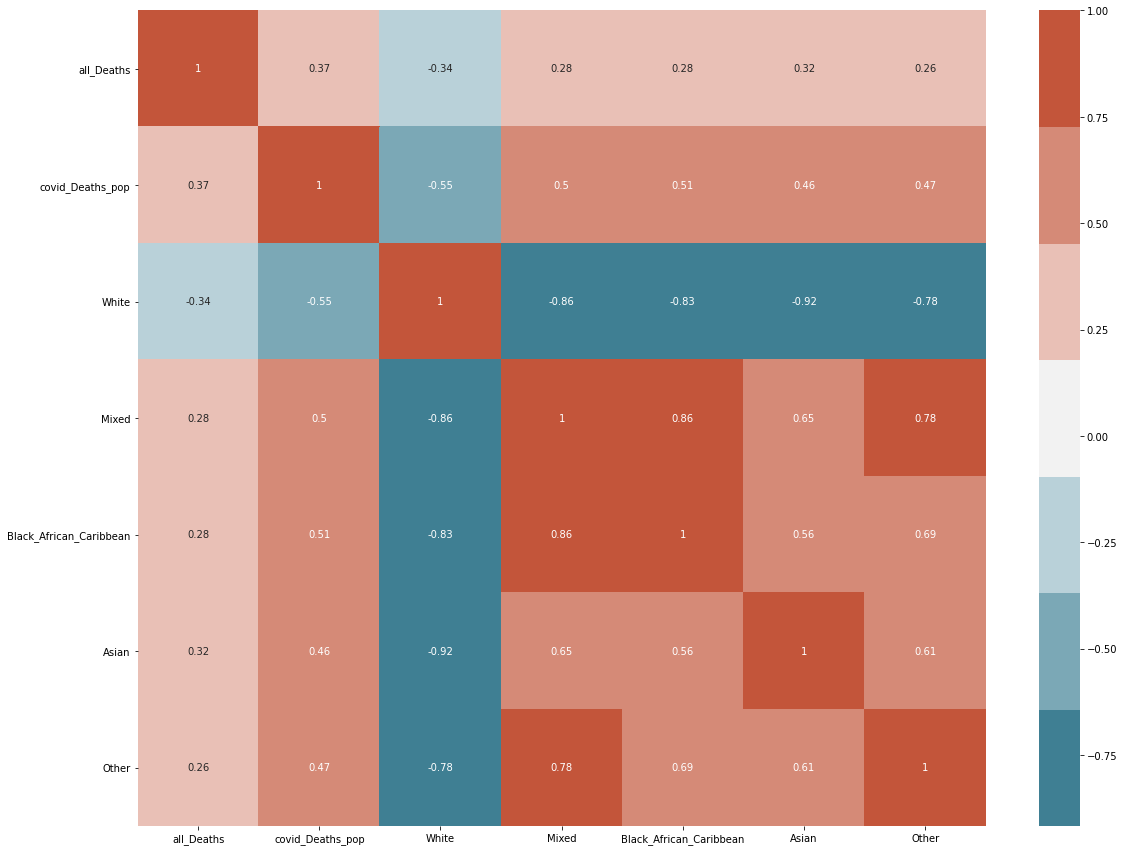

In [11]:
#correlation matrix of relevant variables
plt.figure(figsize=(19, 15))
corrMatrix = df_grouped.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat_grouped.png")




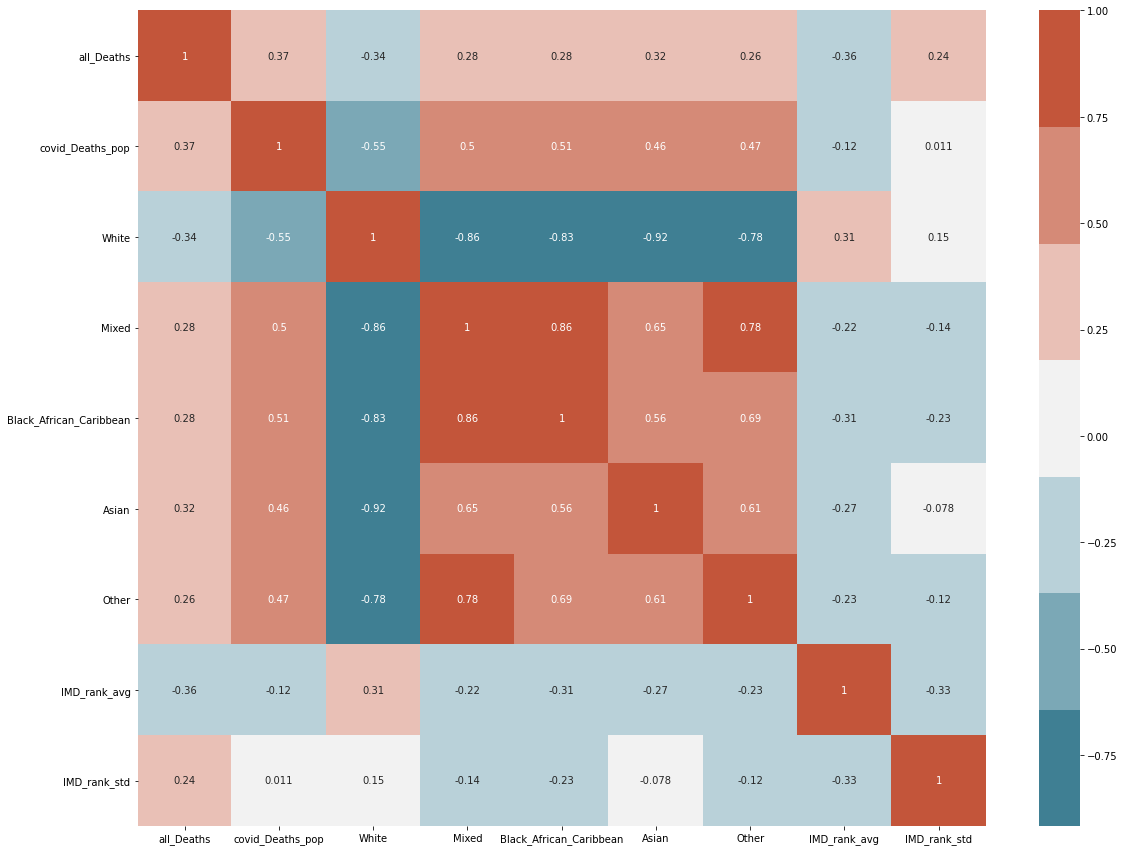

In [12]:
# Adding Deprivation measures
deprv_df = bame_datastore.deprivation.df
deprv_df.drop(columns=['IMD_decile_avg', 'IMD_decile_std'], inplace=True)
ethnic_deprv_df = df_grouped.join(bame_datastore.deprivation.df)
plt.figure(figsize=(19, 15))
corrMatrix = ethnic_deprv_df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
plt.savefig("../reports/figures/deprv_cormat.png")



Density

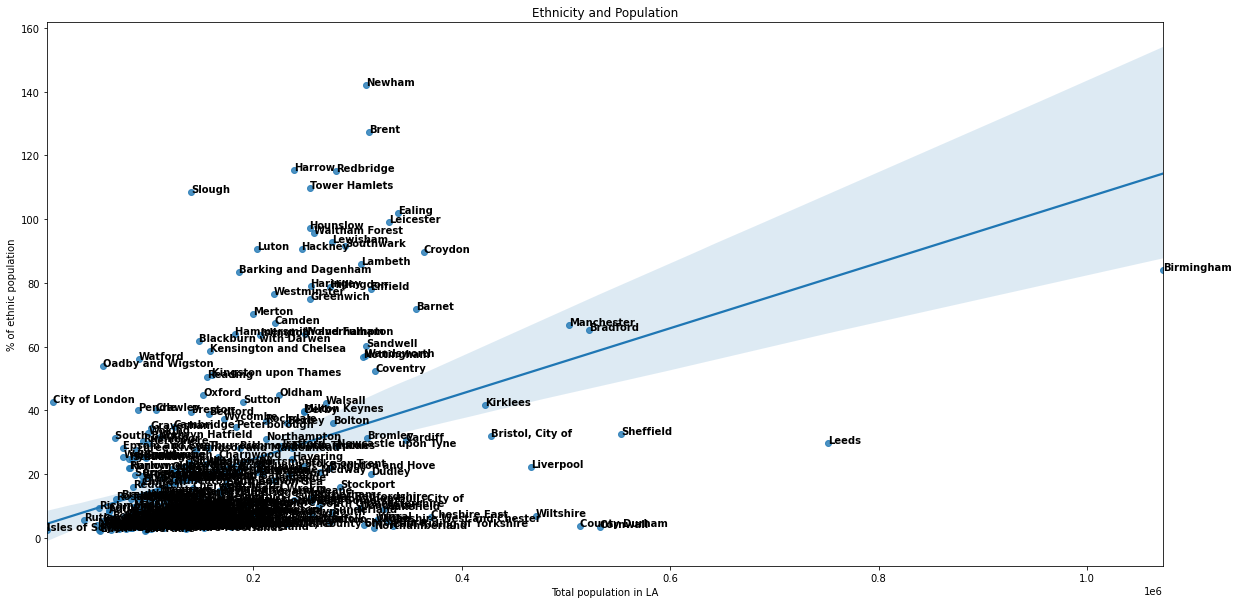

In [13]:
df["total"] = df[df.columns[13:36]].sum(axis=1) #why is this 200??
df["bame"] = df[df.columns[13:31]].sum(axis=1)

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.regplot(x="Denominator", y="bame", data=df) #desnity and bame

for line in range(0,df.shape[0]):
     ax.text(df.Denominator[line]+0.2, df.bame[line], df.index[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
        
ax.set_title(f'Ethnicity and Population')
ax.set_xlabel("Total population in LA")
ax.set_ylabel('% of ethnic population')
plt.savefig(f"../reports/figures/ethnicity_and_density.png")

# Furlough

In [14]:
bame_datastore.lib

{'mortality': ['fbook_covid_data',
  'bame_rpt_deaths',
  'bame_rpt_excess_deaths',
  'ons_deaths'],
 'explanatory': ['ethnicity_data',
  'bame_rpt_cases',
  'furlough_data',
  'key_workers',
  'deprivation'],
 'other': ['lad_geog']}